In [10]:
import torch
import matplotlib.pyplot as plt
import math
from decimal import Decimal

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from nuscenes.nuscenes import NuScenes

import os
from get_2D_boxes_from_sample_data import get_2D_boxes_from_sample_data
import json 

In [2]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(img):
    plt.figure(figsize=(20, 20))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [3]:
def load_nuscenes_image(sample_num):
    '''
    Carrega a imagem da câmera frontal do sample `sample_num`
    '''
    if type(sample_num) == int:
        sample_data = nusc.get('sample_data', nusc.sample[sample_num]['data']['CAM_FRONT'])
        image_path = os.path.join(data_path, sample_data['filename'])
        image = read_image(image_path)
    else:
        sample_data = nusc.get('sample_data', sample_num)
        image_path = os.path.join(data_path, sample_data['filename'])
        image = read_image(image_path)
    return sample_data, image

In [4]:
def get_iou(box1, box2):

    bb1 = dict()
    bb2 = dict()

    bb1['x1'] = box1[0]
    bb1['y1'] = box1[1]
    bb1['x2'] = box1[2]
    bb1['y2'] = box1[3]

    bb2['x1'] = box2[0]
    bb2['y1'] = box2[1]
    bb2['x2'] = box2[2]
    bb2['y2'] = box2[3]
    
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
def distance(box1, box2):
    bb1 = dict()
    bb2 = dict()

    bb1['x1'] = box1[0]
    bb1['y1'] = box1[1]
    bb1['x2'] = box1[2]
    bb1['y2'] = box1[3]

    bb2['x1'] = box2[0]
    bb2['y1'] = box2[1]
    bb2['x2'] = box2[2]
    bb2['y2'] = box2[3]
    
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    point1 = [(bb1['x2'] - bb1['x1']) / 2 + bb1['x1'], (bb1['y2'] - bb1['y1']) / 2 + bb1['y1']]
    point2 = [(bb2['x2'] - bb2['x1']) / 2 + bb2['x1'], (bb2['y2'] - bb2['y1']) / 2 + bb2['y1']]
    
    return math.dist(point1, point2)

In [6]:
def eleven_point_interpolation(precisions, recalls):
    assert len(precisions) == len(recalls)
    precisions = list(precisions)
    recalls = list(recalls)
    
    currentRecall = 0

    AP = 0

    while currentRecall <= 1:
        recalls = list(filter(lambda num: num > currentRecall, recalls))
        del precisions[:len(precisions) - len(recalls)]

        if len(precisions) > 0:
            AP += max(precisions)
        else:
            break
        currentRecall += 0.1

    return AP / 11

In [86]:
path = '../../outputs/faster_rcnn/'

In [ ]:
path = '../../outputs/yolo/'

In [ ]:
path = '../../outputs/ssd/'

In [87]:
size = 'mini'

In [ ]:
size = 'full'

In [102]:
data_path = '../../data'
nusc = NuScenes(version='v1.0-mini', dataroot=data_path, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.283 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [103]:
data = json.load(open(path + 'detections_' + size + '.json'))

In [104]:
gbox = {}
vbox = {}

ginfo = {}
vinfo = {}

In [105]:
gid = 0
vid = 0
for tokens in data:
        boxesTruth, classesTruth = get_2D_boxes_from_sample_data(nusc, tokens, visibilities=['4'])
        gids = []
        for i in range(len(boxesTruth)):
            gids.append(gid)
            ginfo[gid] = {'box': boxesTruth[i], 'label': classesTruth[i]}
            gid += 1
    
        boxes = list(data[tokens]['boxes'])
        classes = list(data[tokens]['labels'])
        vids = []
        for i in range(len(boxes)):
            vids.append(vid)
            vinfo[vid] = {'box': boxes[i], 'label': classes[i]}
            vid += 1
        
        gbox[tokens] = {'boxes': list(boxesTruth), 'labels': list(classesTruth), 'ids': list(gids)}
        vbox[tokens] = {'boxes': list(boxes), 'labels': list(classes), 'ids': list(vids)}

In [106]:
labels = dict({ 'animal' : [],
                'human.pedestrian.adult' : [],
                'human.pedestrian.child' : [],
                'human.pedestrian.construction_worker' : [],
                'human.pedestrian.personal_mobility' : [],
                'human.pedestrian.police_officer' : [],
                'human.pedestrian.stroller' : [],
                'human.pedestrian.wheelchair' : [],
                'movable_object.barrier' : [],
                'movable_object.debris' : [],
                'movable_object.pushable_pullable' : [],
                'movable_object.trafficcone' : [],
                'static_object.bicycle_rack' : [],
                'vehicle.bicycle' : [],
                'vehicle.bus.bendy' : [],
                'vehicle.bus.rigid' : [],
                'vehicle.car' : [],
                'vehicle.construction' : [],
                'vehicle.emergency.ambulance' : [],
                'vehicle.emergency.police' : [],
                'vehicle.motorcycle' : [],
                'vehicle.trailer' : [],
                'vehicle.truck' : [],
                'total': []
              })
for i in labels:
    for j in range(0, 102):
        labels[i].append({'TP' : 0, 'FP' : 0, 'FN' : 0, 'Precision' : 0, 'Recall' : 0, 'Accuracy' : 0, 'IoU' : 0, 'CPrecision' : [], 'CRecall' : [], 'AP': 0})

In [107]:
data = json.load(open(path + 'detections_' + size + '.json'))

IoUBased = []
distanceBased = []

qtt = 0

for tokens in data:
    gb, gl, gid = list(gbox[tokens]['boxes']), list(gbox[tokens]['labels']), list(gbox[tokens]['ids'])
    vb, vl, vid = list(vbox[tokens]['boxes']), list(vbox[tokens]['labels']), list(vbox[tokens]['ids'])

    for i in list(gb):
        pos, IoU = 0, 0
        posG = gb.index(i)
        for posV, j in enumerate(vb):
            currentIoU = get_iou(i, j)

            if currentIoU > IoU:
                pos, IoU = posV, currentIoU

        if len(vb) >= 1:
            IoUBased.append({'iou': IoU, 'distance': distance(i, vb[pos]), 'gid': gid[posG], 'vid': vid[pos]})
            vb.pop(pos)
            vl.pop(pos)
            vid.pop(pos)
        else:
            IoUBased.append({'iou': 0, 'distance': 0, 'gid': gid[posG], 'vid': None})
            qtt+=1

        gb.pop(posG)
        gl.pop(posG)
        gid.pop(posG)

    for i in vid:
        IoUBased.append({'iou': 0, 'distance': 0, 'gid': None, 'vid': i})

for tokens in data:
    gb, gl, gid = list(gbox[tokens]['boxes']), list(gbox[tokens]['labels']), list(gbox[tokens]['ids'])
    vb, vl, vid = list(vbox[tokens]['boxes']), list(vbox[tokens]['labels']), list(vbox[tokens]['ids'])

    for i in list(gb):
        pos, dist = 0, math.inf
        posG = gb.index(i)
        for posV, j in enumerate(vb):
            currentDist = distance(i, j)

            if currentDist < dist:
                pos, dist = posV, currentDist

        if len(vb) >= 1:
            distanceBased.append({'iou': get_iou(i, vb[pos]), 'distance': dist, 'gid': gid[posG], 'vid': vid[pos]})
            vb.pop(pos)
            vl.pop(pos)
            vid.pop(pos)
        else:
            distanceBased.append({'iou': 0, 'distance': 0, 'gid': gid[posG], 'vid': None})
            qtt+=1

        gb.pop(posG)
        gl.pop(posG)
        gid.pop(posG)

    for i in vid:
        distanceBased.append({'iou': 0, 'distance': 0, 'gid': None, 'vid': i})

IoUBased = sorted(IoUBased, key=lambda d: d['iou'], reverse=True)
distanceBased = sorted(distanceBased, key=lambda d: d['iou'], reverse=True)

In [108]:
threshold = Decimal('0.00')

labels = dict({ 'animal' : [],
                'human.pedestrian.adult' : [],
                'human.pedestrian.child' : [],
                'human.pedestrian.construction_worker' : [],
                'human.pedestrian.personal_mobility' : [],
                'human.pedestrian.police_officer' : [],
                'human.pedestrian.stroller' : [],
                'human.pedestrian.wheelchair' : [],
                'movable_object.barrier' : [],
                'movable_object.debris' : [],
                'movable_object.pushable_pullable' : [],
                'movable_object.trafficcone' : [],
                'static_object.bicycle_rack' : [],
                'vehicle.bicycle' : [],
                'vehicle.bus.bendy' : [],
                'vehicle.bus.rigid' : [],
                'vehicle.car' : [],
                'vehicle.construction' : [],
                'vehicle.emergency.ambulance' : [],
                'vehicle.emergency.police' : [],
                'vehicle.motorcycle' : [],
                'vehicle.trailer' : [],
                'vehicle.truck' : [],
                'total': []
              })
for i in labels:
    for j in range(0, 102):
        labels[i].append({'TP' : 0, 'FP' : 0, 'FN' : 0, 'Precision' : 0, 'Recall' : 0, 'Accuracy' : 0, 'IoU' : 0, 'CPrecision' : [], 'CRecall' : [], 'AP': 0})


data = IoUBased
#data = distanceBased

while threshold <= 1:
    for i in data:
        if i['gid'] and i['vid']:
            if i['iou'] > threshold and vinfo[i['vid']]['label'] == ginfo[i['gid']]['label']:
                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] += 1
                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['IoU'] += i['iou']
                labels['total'][int(threshold * 100)]['TP'] += 1
                labels['total'][int(threshold * 100)]['IoU'] += i['iou']

                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['CPrecision'].append(labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] / max(1, labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] + labels[vinfo[i['vid']]['label']][int(threshold * 100)]['FP']))
                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['CRecall'].append(labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'])
                labels['total'][int(threshold * 100)]['CPrecision'].append(labels['total'][int(threshold * 100)]['TP'] / max(1, labels['total'][int(threshold * 100)]['TP'] + labels['total'][int(threshold * 100)]['FP']))
                labels['total'][int(threshold * 100)]['CRecall'].append(labels['total'][int(threshold * 100)]['TP'])
            
            else:
                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['FP'] += 1
                labels['total'][int(threshold * 100)]['FP'] += 1
                
                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['CPrecision'].append(labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] / max(1, labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] + labels[vinfo[i['vid']]['label']][int(threshold * 100)]['FP']))
                labels[vinfo[i['vid']]['label']][int(threshold * 100)]['CRecall'].append(labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'])
                labels['total'][int(threshold * 100)]['CPrecision'].append(labels['total'][int(threshold * 100)]['TP'] / max(1, labels['total'][int(threshold * 100)]['TP'] + labels['total'][int(threshold * 100)]['FP']))
                labels['total'][int(threshold * 100)]['CRecall'].append(labels['total'][int(threshold * 100)]['TP'])
            pass
        elif i['gid']:
            labels[ginfo[i['gid']]['label']][int(threshold * 100)]['FN'] += 1
            labels['total'][int(threshold * 100)]['FN'] += 1
        else:
            labels[vinfo[i['vid']]['label']][int(threshold * 100)]['FP'] += 1
            labels['total'][int(threshold * 100)]['FP'] += 1

            labels[vinfo[i['vid']]['label']][int(threshold * 100)]['CPrecision'].append(labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] / max(1, labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'] + labels[vinfo[i['vid']]['label']][int(threshold * 100)]['FP']))
            labels[vinfo[i['vid']]['label']][int(threshold * 100)]['CRecall'].append(labels[vinfo[i['vid']]['label']][int(threshold * 100)]['TP'])
            labels['total'][int(threshold * 100)]['CPrecision'].append(labels['total'][int(threshold * 100)]['TP'] / max(1, labels['total'][int(threshold * 100)]['TP'] + labels['total'][int(threshold * 100)]['FP']))
            labels['total'][int(threshold * 100)]['CRecall'].append(labels['total'][int(threshold * 100)]['TP'])


    qtt = 0
    for i in labels:
        labels[i][int(threshold * 100)]['Precision'] = labels[i][int(threshold * 100)]['TP'] / max((labels[i][int(threshold * 100)]['TP'] + labels[i][int(threshold * 100)]['FP']), 1)
        labels[i][int(threshold * 100)]['Recall'] = labels[i][int(threshold * 100)]['TP'] / max((labels[i][int(threshold * 100)]['TP'] + labels[i][int(threshold * 100)]['FN']), 1)
        labels[i][int(threshold * 100)]['Accuracy'] = labels[i][int(threshold * 100)]['TP'] / max((labels[i][int(threshold * 100)]['TP'] + labels[i][int(threshold * 100)]['FP'] + labels[i][int(threshold * 100)]['FN']), 1)    

        if labels[i][int(threshold * 100)]['TP'] or labels[i][int(threshold * 100)]['FP'] or labels[i][int(threshold * 100)]['FN']:
            qtt+=1
        
        for j in range(len(labels[i][int(threshold * 100)]['CRecall'])):
            labels[i][int(threshold * 100)]['CRecall'][j] /= max((labels[i][int(threshold * 100)]['TP'] + labels[i][int(threshold * 100)]['FP']), 1)
        
        if i != 'total':
            labels[i][int(threshold * 100)]['AP'] = eleven_point_interpolation(labels[i][int(threshold * 100)]['CPrecision'], labels[i][int(threshold * 100)]['CRecall'])
            labels['total'][int(threshold * 100)]['AP'] += labels[i][int(threshold * 100)]['AP']
        else:
            labels['total'][int(threshold * 100)]['AP'] /= qtt#(len(list(labels))-1)

        del labels[i][int(threshold * 100)]['CPrecision']
        del labels[i][int(threshold * 100)]['CRecall']
    
    threshold += Decimal('0.01')

In [109]:
#plt.plot(labels['total'][50]['CRecall'], labels['total'][50]['CPrecision'], linewidth=4, color="red")
#plt.xlabel("Recall", fontsize=12, fontweight='bold')
#plt.ylabel("Precision", fontsize=12, fontweight='bold')
#plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
#plt.show()

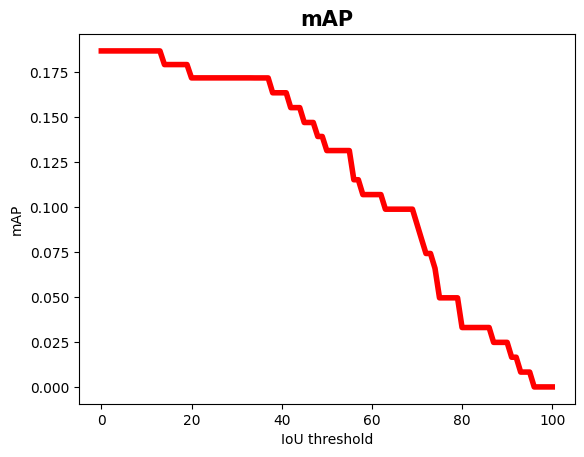

In [118]:
plt.plot([data['AP'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('mAP', fontsize=15, fontweight="bold")
plt.ylabel('mAP')
plt.xlabel('IoU threshold')
plt.savefig(path + 'mAP_' + size + '.png')
plt.show()

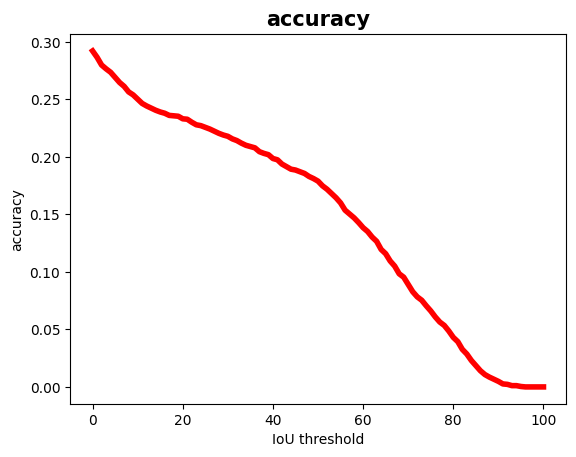

In [119]:
plt.plot([data['Accuracy'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('accuracy', fontsize=15, fontweight="bold")
plt.ylabel('accuracy')
plt.xlabel('IoU threshold')
plt.savefig(path + 'accuracy_' + size + '.png')
plt.show()

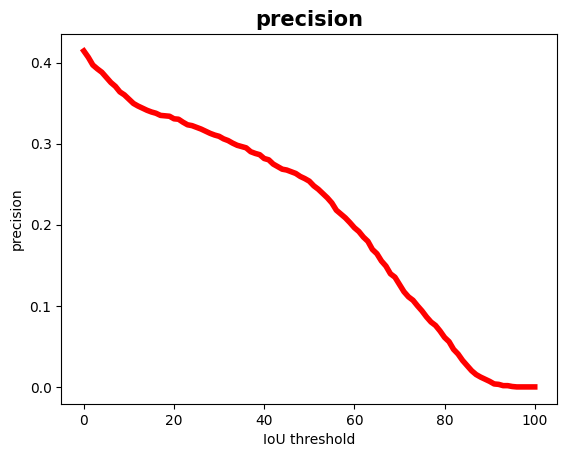

In [120]:
plt.plot([data['Precision'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('precision', fontsize=15, fontweight="bold")
plt.ylabel('precision')
plt.xlabel('IoU threshold')
plt.savefig(path + 'precision_' + size + '.png')
plt.show()

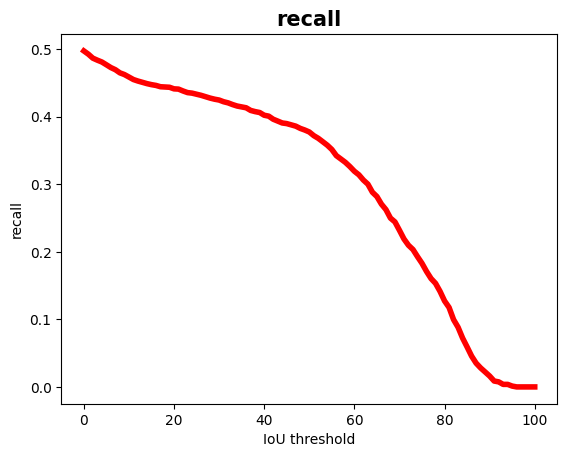

In [121]:
plt.plot([data['Recall'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('recall', fontsize=15, fontweight="bold")
plt.ylabel('recall')
plt.xlabel('IoU threshold')
plt.savefig(path + 'recall_' + size + '.png')
plt.show()

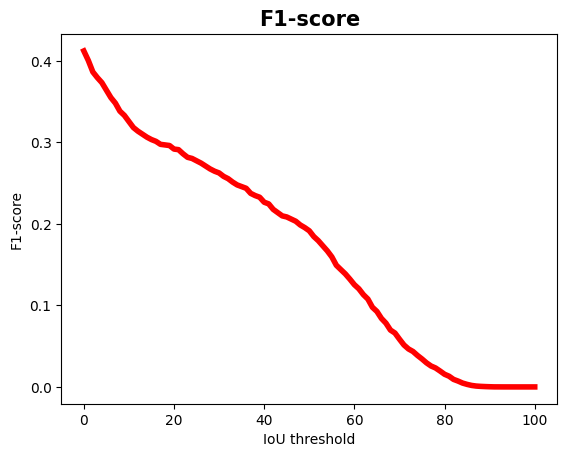

In [122]:
plt.plot([2 * data['Precision'] * data['Recall'] / max(1, data['Precision'] + data['Recall']) for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('F1-score', fontsize=15, fontweight="bold")
plt.ylabel('F1-score')
plt.xlabel('IoU threshold')
plt.savefig(path + 'F1_' + size + '.png')
plt.show()

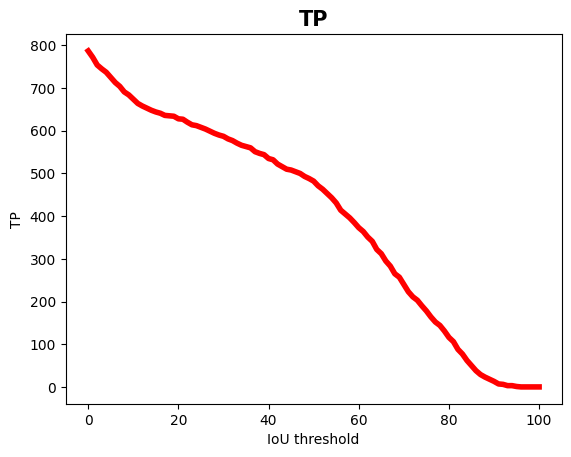

In [115]:
plt.plot([data['TP'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('TP', fontsize=15, fontweight="bold")
plt.ylabel('TP')
plt.xlabel('IoU threshold')
plt.show()

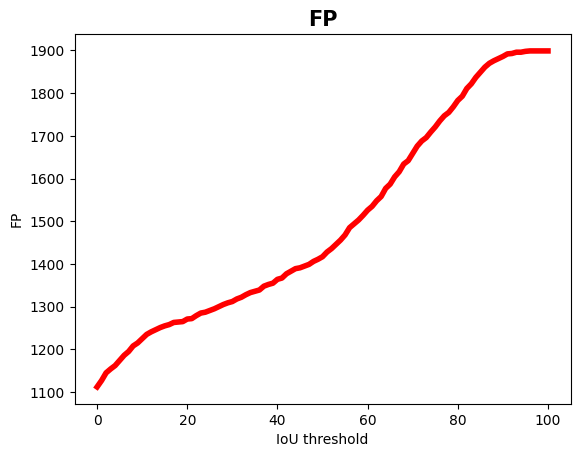

In [116]:
plt.plot([data['FP'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('FP', fontsize=15, fontweight="bold")
plt.ylabel('FP')
plt.xlabel('IoU threshold')
plt.show()

In [117]:
with open(path + 'metrics_' + size + '.json', 'w', encoding ='utf8', newline='\n') as json_file:
    json.dump(labels, json_file, ensure_ascii = True, indent=2)